In [16]:
# Written by Nicole Pham
# Modified by Riley Wong
import requests           
from io import StringIO

import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import OrdinalEncoder, LabelEncoder, StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import zero_one_loss

import warnings
warnings.filterwarnings('ignore')

# Fix the random seed for reproducibility
# !! Important !! : do not change this
seed = 1234
np.random.seed(seed) 

In [3]:
# Written by Nicole Pham
# Feature - Name List
features = 'age workclass fnlwgt education education-num marital-status occupation relationship race sex capital-gain capital-loss hours-per-week native-country'
features = features.split(' ')

In [4]:
# Written by Nicole Pham
# Modified by Riley Wong
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data'

with requests.get(url) as link:
    datafile = StringIO(link.text)
    
    adults_X = []
    adults_y = []
    for line in datafile:
        split_line = line[:-1].split(', ')
        if len(split_line) == 15:
            # Ignore data that is missing features
            for x in split_line[:-1]:
              if x == '?':
                break
            else:
              adults_X.append([x for x in split_line[:-1]])
              adults_y.append([split_line[-1]])

    # Since not all of the inputs are numbers (there is categorical data), we need to use
    # an ordinal encoder which will translate these into integers
    ord_enc = OrdinalEncoder()
    adults_X = ord_enc.fit_transform(adults_X)
    
    label_enc = LabelEncoder()
    adults_y = label_enc.fit_transform(adults_y)

In [5]:
# Written by Nicole Pham
adults_X = np.asarray(adults_X)
adults_y = np.asarray(adults_y)

print(adults_X.shape)
print(adults_y.shape)

(30162, 14)
(30162,)


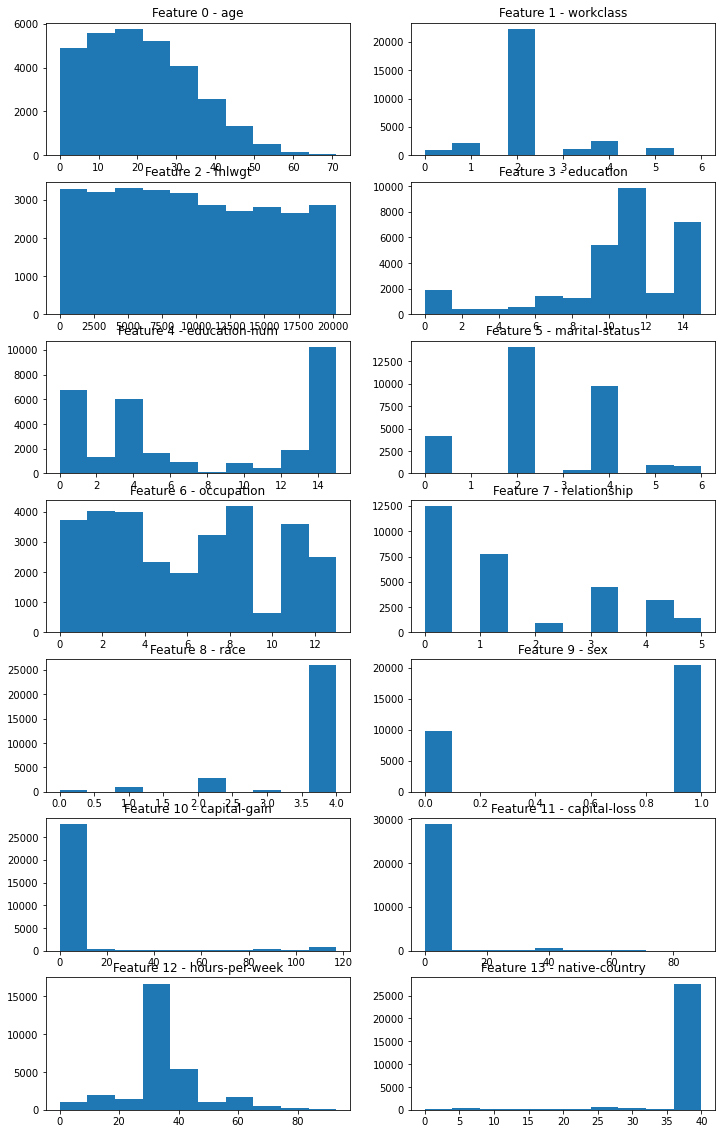

In [6]:
# Written by Nicole Pham
# Create a figure with 7 rows and 2 column
fig, axes = plt.subplots(7, 2, figsize=(12, 20))

for i in range(7):
    for j in range(2):
        adult_feature = adults_X[:,(i * 2) + j]
        axes[i][j].hist(adult_feature)
        axes[i][j].set_title(f'Feature {(i * 2) + j} - {features[(i * 2) + j]}')

In [7]:
# Written by Riley Wong
# Normalize data before training neural network

scaler = StandardScaler()
scaler.fit(adults_X)
adults_X = scaler.transform(adults_X)

In [8]:
# Written by Nicole Pham
# Since we're dealing with a large dataset here, we decided to use a neural network in order to
# have some flexibility with our model.

adults_X_tr, adults_X_te, adults_y_tr, adults_y_te = train_test_split(adults_X, adults_y, test_size=0.1, random_state=seed, shuffle=True)

learner_1 = MLPClassifier(
            hidden_layer_sizes = (64), activation = 'relu',
            solver = 'sgd', learning_rate = 'constant',
            learning_rate_init = 0.05, batch_size = 256, 
            max_iter = 100, n_iter_no_change = 100,
            random_state = seed)
learner_2 = MLPClassifier(
            hidden_layer_sizes = (128), activation = 'relu',
            solver = 'sgd', learning_rate = 'constant',
            learning_rate_init = 0.001, batch_size = 256, 
            max_iter = 100, n_iter_no_change = 100,
            random_state = seed)
learner_3 = MLPClassifier(
            hidden_layer_sizes=(64), activation='relu',
            solver = 'sgd', learning_rate = 'constant', 
            learning_rate_init = 0.001, batch_size = 256,
            random_state = seed)

train_sizes = [100, 1000, 5000, 10000, 20000, 30000]
neural_tr_errors1 = []
neural_te_errors1 = []

neural_tr_errors2 = []
neural_te_errors2 = []

neural_tr_errors3 = []
neural_te_errors3 = []

for size in train_sizes:
    new_adults_X_tr = adults_X_tr[:size, :]
    new_adults_y_tr = adults_y_tr[:size]
    
    learner_1.fit(new_adults_X_tr, new_adults_y_tr)
    learner_2.fit(new_adults_X_tr, new_adults_y_tr)
    learner_3.fit(new_adults_X_tr, new_adults_y_tr)
    
    # Compute the training and test error rates for first learner
    YtHat = learner_1.predict(new_adults_X_tr)
    YeHat = learner_1.predict(adults_X_te)
    neural_tr_errors1.append(zero_one_loss(YtHat, new_adults_y_tr))
    neural_te_errors1.append(zero_one_loss(YeHat, adults_y_te))
    
    # Compute the training and test error rates for second learner
    YtHat = learner_2.predict(new_adults_X_tr)
    YeHat = learner_2.predict(adults_X_te)
    neural_tr_errors2.append(zero_one_loss(YtHat, new_adults_y_tr))
    neural_te_errors2.append(zero_one_loss(YeHat, adults_y_te))
    
    YtHat = learner_3.predict(new_adults_X_tr)
    YeHat = learner_3.predict(adults_X_te)
    neural_tr_errors3.append(zero_one_loss(YtHat, new_adults_y_tr))
    neural_te_errors3.append(zero_one_loss(YeHat, adults_y_te))

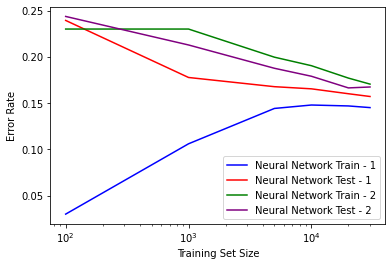

In [9]:
# Written by Nicole Pham

plt.semilogx(train_sizes, neural_tr_errors1, color='blue', label='Neural Network Train - 1')
plt.semilogx(train_sizes, neural_te_errors1, color='red', label='Neural Network Test - 1')

plt.semilogx(train_sizes, neural_tr_errors2, color='green', label='Neural Network Train - 2')
plt.semilogx(train_sizes, neural_te_errors2, color='purple', label='Neural Network Test - 2')

plt.xlabel('Training Set Size')
plt.ylabel('Error Rate')
plt.legend(fontsize = 10, loc = 0)

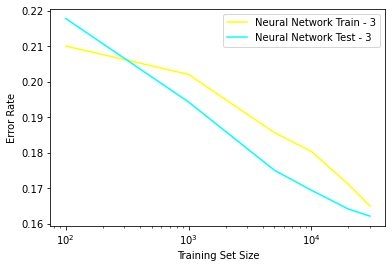

In [10]:
# Written by Nicole Pham
plt.semilogx(train_sizes, neural_tr_errors3, color='yellow', label='Neural Network Train - 3')
plt.semilogx(train_sizes, neural_te_errors3, color='cyan', label='Neural Network Test - 3')

plt.xlabel('Training Set Size')
plt.ylabel('Error Rate')
plt.legend(fontsize = 10, loc = 0)

In [29]:
# Written by Riley Wong
# Using RandomizedSearchCV to tune hyperparameters

learner = MLPClassifier(random_state=seed)

parameter_space = {
    'hidden_layer_sizes': [(80), (85), (90), (95), (100), (105), (110)],
    'activation': ['relu'],
    'solver': ['adam'],
    'alpha': [0.001, 0.01, 0.1],
    'batch_size': [175, 200, 225, 250],
    'learning_rate_init': [0.0001, 0.001, 0.01, 0.1],
}

clf = RandomizedSearchCV(learner, parameter_space, n_iter=50, n_jobs=-1, cv=3)
clf.fit(adults_X_tr, adults_y_tr)

print(clf.best_params_)

{'solver': 'adam', 'learning_rate_init': 0.001, 'hidden_layer_sizes': 95, 'batch_size': 175, 'alpha': 0.1, 'activation': 'relu'}


Top 3 hyperparameters from RandomizedSearchCV: 

{'solver': 'adam', 'learning_rate_init': 0.01, 'hidden_layer_sizes': 80, 'batch_size': 250, 'alpha': 0.1, 'activation': 'relu'}

{'solver': 'adam', 'learning_rate_init': 0.001, 'hidden_layer_sizes': 90, 'batch_size': 200, 'alpha': 0.1, 'activation': 'relu'}

{'solver': 'adam', 'learning_rate_init': 0.001, 'hidden_layer_sizes': 95, 'batch_size': 175, 'alpha': 0.1, 'activation': 'relu'}

In [31]:
# Written by Riley Wong
# Comparing top 4 learners

learner_1 = MLPClassifier(
            hidden_layer_sizes = (64), activation = 'relu',
            solver = 'sgd', learning_rate = 'constant',
            learning_rate_init = 0.05, batch_size = 256, 
            max_iter = 100, n_iter_no_change = 100,
            random_state = seed)
learner_2 = MLPClassifier(
            hidden_layer_sizes = (80), activation = 'relu',
            solver = 'adam', learning_rate = 'constant',
            learning_rate_init = 0.01, batch_size = 250, 
            alpha=0.1, random_state = seed)
learner_3 = MLPClassifier(
            hidden_layer_sizes = (90), activation = 'relu',
            solver = 'adam', learning_rate = 'constant',
            learning_rate_init = 0.001, batch_size = 200, 
            alpha=0.1, random_state = seed)
learner_4 = MLPClassifier(
            hidden_layer_sizes = (95), activation = 'relu',
            solver = 'adam', learning_rate = 'constant',
            learning_rate_init = 0.001, batch_size = 175, 
            alpha=0.1, random_state = seed)

train_sizes = [100, 1000, 5000, 10000, 20000, 30000]
neural_tr_errors1 = []
neural_te_errors1 = []

neural_tr_errors2 = []
neural_te_errors2 = []

neural_tr_errors3 = []
neural_te_errors3 = []

neural_tr_errors4 = []
neural_te_errors4 = []

for size in train_sizes:
    new_adults_X_tr = adults_X_tr[:size, :]
    new_adults_y_tr = adults_y_tr[:size]
    
    learner_1.fit(new_adults_X_tr, new_adults_y_tr)
    learner_2.fit(new_adults_X_tr, new_adults_y_tr)
    learner_3.fit(new_adults_X_tr, new_adults_y_tr)
    learner_4.fit(new_adults_X_tr, new_adults_y_tr)
    
    # Compute the training and test error rates for first learner
    YtHat = learner_1.predict(new_adults_X_tr)
    YeHat = learner_1.predict(adults_X_te)
    neural_tr_errors1.append(zero_one_loss(YtHat, new_adults_y_tr))
    neural_te_errors1.append(zero_one_loss(YeHat, adults_y_te))
    
    # Compute the training and test error rates for second learner
    YtHat = learner_2.predict(new_adults_X_tr)
    YeHat = learner_2.predict(adults_X_te)
    neural_tr_errors2.append(zero_one_loss(YtHat, new_adults_y_tr))
    neural_te_errors2.append(zero_one_loss(YeHat, adults_y_te))
    
    # Compute the training and test error rates for third learner
    YtHat = learner_3.predict(new_adults_X_tr)
    YeHat = learner_3.predict(adults_X_te)
    neural_tr_errors3.append(zero_one_loss(YtHat, new_adults_y_tr))
    neural_te_errors3.append(zero_one_loss(YeHat, adults_y_te))

    # Compute the training and test error rates for fourth learner
    YtHat = learner_4.predict(new_adults_X_tr)
    YeHat = learner_4.predict(adults_X_te)
    neural_tr_errors4.append(zero_one_loss(YtHat, new_adults_y_tr))
    neural_te_errors4.append(zero_one_loss(YeHat, adults_y_te))

Neural Network Train - 1: [0.030000000000000027, 0.10599999999999998, 0.1442, 0.14790000000000003, 0.14690000000000003, 0.14510959661079392]
Neural Network Test - 1: [0.239310573417302, 0.17765992707988065, 0.16771627444481274, 0.1653960888299636, 0.16009280742459397, 0.1571097116340736]
Neural Network Train - 2: [0.0, 0.025000000000000022, 0.12380000000000002, 0.1493, 0.15144999999999997, 0.15262479277951746]
Neural Network Test - 2: [0.24063639376864432, 0.18793503480278417, 0.17699701690420944, 0.16373881339078555, 0.1571097116340736, 0.15147497514086838]
Neural Network Train - 3: [0.050000000000000044, 0.10299999999999998, 0.135, 0.14839999999999998, 0.14664999999999995, 0.14735678762202986]
Neural Network Test - 3: [0.2257209148160424, 0.17898574743122309, 0.1617500828637719, 0.15478952601922435, 0.15810407689758033, 0.1521378853165396]
Neural Network Train - 4: [0.06000000000000005, 0.09999999999999998, 0.13739999999999997, 0.1482, 0.1481, 0.14798305396942346]
Neural Network Test

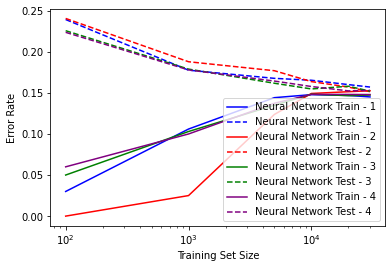

In [32]:
# Written by Riley Wong

print("Neural Network Train - 1:", neural_tr_errors1)
print("Neural Network Test - 1:", neural_te_errors1)
print("Neural Network Train - 2:", neural_tr_errors2)
print("Neural Network Test - 2:", neural_te_errors2)
print("Neural Network Train - 3:", neural_tr_errors3)
print("Neural Network Test - 3:", neural_te_errors3)
print("Neural Network Train - 4:", neural_tr_errors4)
print("Neural Network Test - 4:", neural_te_errors4)

plt.semilogx(train_sizes, neural_tr_errors1, color='blue', label='Neural Network Train - 1')
plt.semilogx(train_sizes, neural_te_errors1, linestyle="dashed", color='blue', label='Neural Network Test - 1')

plt.semilogx(train_sizes, neural_tr_errors2, color='red', label='Neural Network Train - 2')
plt.semilogx(train_sizes, neural_te_errors2, linestyle="dashed", color='red', label='Neural Network Test - 2')

plt.semilogx(train_sizes, neural_tr_errors3, color='green', label='Neural Network Train - 3')
plt.semilogx(train_sizes, neural_te_errors3, linestyle="dashed", color='green', label='Neural Network Test - 3')

plt.semilogx(train_sizes, neural_tr_errors4, color='purple', label='Neural Network Train - 4')
plt.semilogx(train_sizes, neural_te_errors4, linestyle="dashed", color='purple', label='Neural Network Test - 4')

plt.xlabel('Training Set Size')
plt.ylabel('Error Rate')
plt.legend(fontsize = 10, loc = 0)

Neural network 2 is the best with the following parameters:

{'solver': 'adam', 'learning_rate_init': 0.01, 'hidden_layer_sizes': 80, 'batch_size': 250, 'alpha': 0.1, 'activation': 'relu'}